In [2]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import pickle
from pathlib import Path
import os

# from ase.io import read
# from qtpyt.basis import Basis
# from qtpyt.surface.principallayer import PrincipalSelfEnergy
# from qtpyt.surface.tools import prepare_leads_matrices
# from qtpyt.tools import remove_pbc, rotate_couplings
# from qtpyt.block_tridiag import graph_partition

maroon_cmap = LinearSegmentedColormap.from_list(
    "white_to_maroon",
    ["white", "#800000"],
    N=256
)
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/vertex_correction/pentadienyl/projection_mol_space'
os.chdir(new_path)

In [3]:
def compute_gamma_from_sigma(sigma: np.ndarray) -> np.ndarray:
    """
    Compute the broadening matrix Γ from a retarded self-energy Σ.

    Parameters
    ----------
    sigma : np.ndarray
        Retarded self-energy matrix Σ^r(ω) (square, complex), shape (N, N).

    Returns
    -------
    np.ndarray
        Broadening matrix Γ(ω), shape (N, N), complex.

    Notes
    -----
    The broadening is defined as

        Γ(ω) = i [Σ^r(ω) - Σ^a(ω)].

    With the advanced self-energy given by Σ^a = (Σ^r)†, this becomes

        Γ(ω) = i [Σ^r(ω) - (Σ^r(ω))†].

    In code, this is implemented as

        Γ = 1j * (sigma - sigma.conj().T).

    Γ is Hermitian when Σ is a proper retarded self-energy (numerically it may have
    tiny non-Hermitian components; the expression above enforces Hermitian structure
    up to floating-point error).
    """
    return 1j * (sigma - sigma.conj().T)


def compute_transmission(
    sigma_L: np.ndarray, sigma_R: np.ndarray, G_r: np.ndarray
) -> float:
    """
    Compute the Landauer transmission T(E) from projected self-energies and the retarded Green's function.

    Parameters
    ----------
    sigma_L : np.ndarray
        Left retarded self-energy on the molecular subspace Σ_L^r(E), shape (N_mol, N_mol).
    sigma_R : np.ndarray
        Right retarded self-energy on the molecular subspace Σ_R^r(E), shape (N_mol, N_mol).
    G_r : np.ndarray
        Retarded Green's function on the molecular subspace G^r(E), shape (N_mol, N_mol).

    Returns
    -------
    float
        Transmission T(E) (real scalar). Any small imaginary part produced by finite numerical
        precision is discarded via `np.real(...)`.

    Notes
    -----
    The transmission is computed as

        T(E) = Tr[ Γ_L(E) G^r(E) Γ_R(E) G^a(E) ],

    where

        Γ_{L/R}(E) = i [Σ_{L/R}^r(E) - Σ_{L/R}^a(E)]
                   = i [Σ_{L/R}^r(E) - (Σ_{L/R}^r(E))†],

    and

        G^a(E) = (G^r(E))†.

    Matrix operations:
    - Compute Γ_L and Γ_R from Σ_L and Σ_R
    - Form G^a as the conjugate transpose of G^r
    - Multiply in the order Γ_L @ G^r @ Γ_R @ G^a
    - Take the trace and keep the real part
    """
    G_a = G_r.conj().T
    gamma_L = compute_gamma_from_sigma(sigma_L)
    gamma_R = compute_gamma_from_sigma(sigma_R)
    return float(np.real(np.trace(gamma_L @ G_r @ gamma_R @ G_a)))


def combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, side: str):
    """
    Merge selected lead and tip Hamiltonian/overlap blocks into a single (lead+tip) block
    and build the corresponding coupling block to the molecular region.

    Parameters
    ----------
    hs_list_ii : list
        List of on-site (diagonal) blocks [(H_i, S_i), ...]. Each H_i, S_i is a square matrix.
        This function assumes a specific indexing convention:
        - left uses indices 0 (bulk) and 1 (tip)
        - molecule is index 2 (not merged here)
        - right uses indices 3 (tip) and 4 (bulk)
    hs_list_ij : list
        List of off-diagonal coupling blocks [(H_ij, S_ij), ...] consistent with hs_list_ii.
        This function assumes a specific indexing convention:
        - left lead<->tip coupling is hs_list_ij[0]
        - left (tip -> mol) coupling is hs_list_ij[1]
        - (mol -> right tip) coupling is hs_list_ij[2]
        - right tip<->bulk coupling is hs_list_ij[3]
    side : str
        Which side to build. Must be "left" or "right".

    Returns
    -------
    tuple[list, list]
        (hs_ii_merge, hs_ij_merge)

        hs_ii_merge : list
            A one-element list [(H_merge, S_merge)] containing the merged (lead+tip) on-site
            block, shape (N_full, N_full).
        hs_ij_merge : list
            A one-element list containing the coupling between the merged (lead+tip) space and
            the molecular space. The orientation depends on `side`:

            - side == "left": returns [(H_lm_merge, S_lm_merge)] with shape (N_full, N_mol),
              i.e. (lead+tip -> mol)
            - side == "right": returns [(H_mr_merge, S_mr_merge)] with shape (N_mol, N_full),
              i.e. (mol -> lead+tip)

    Notes
    -----
    Block assembly (generic):
        H_merge = [ H_A      H_coup     ]
                  [ H_coup†  H_B        ]

        S_merge = [ S_A      S_coup     ]
                  [ S_coup†  S_B        ]

    where A/B are the chosen sub-blocks (bulk and tip, ordered depending on side) and † denotes
    conjugate transpose.

    Left side bookkeeping used here:
    - Order is [bulk, tip] in the merged space.
    - The coupling returned is (lead+tip -> mol), built by vertically padding zeros to align the
      molecule coupling with the tip part of the merged space:

        H_lm_merge = [ 0_(N_bulk, N_mol) ]
                     [ H_tip,mol        ]

      (same for S).

    Right side bookkeeping used here:
    - Order is [tip, bulk] in the merged space.
    - The coupling returned is (mol -> lead+tip), built by horizontally padding zeros to align
      the coupling with the tip part of the merged space:

        H_mr_merge = [ H_mol,tip   0_(N_mol, N_bulk) ]

      (same for S).

    This asymmetry in orientation is intentional and matches how `compute_projected_self_energy`
    branches on `direction` (left expects H_lm; right expects H_ml).
    """
    if side == "left":
        H_bulk, S_bulk = hs_list_ii[0]
        H_tip, S_tip = hs_list_ii[1]
        H_coup, S_coup = hs_list_ij[0]

        H_merge = np.block([[H_bulk, H_coup], [H_coup.T.conj(), H_tip]])
        S_merge = np.block([[S_bulk, S_coup], [S_coup.T.conj(), S_tip]])

        H_lm, S_lm = hs_list_ij[1]
        H_lm_merge = np.vstack([np.zeros((810, 136)), H_lm])
        S_lm_merge = np.vstack([np.zeros((810, 136)), S_lm])

        return [(H_merge, S_merge)], [(H_lm_merge, S_lm_merge)]

    if side == "right":
        H_tip, S_tip = hs_list_ii[3]
        H_bulk, S_bulk = hs_list_ii[4]
        H_coup, S_coup = hs_list_ij[3]

        H_merge = np.block([[H_tip, H_coup], [H_coup.T.conj(), H_bulk]])
        S_merge = np.block([[S_tip, S_coup], [S_coup.T.conj(), S_bulk]])

        H_mr, S_mr = hs_list_ij[2]
        H_mr_merge = np.hstack([H_mr, np.zeros((136, 810))])
        S_mr_merge = np.hstack([S_mr, np.zeros((136, 810))])

        return [(H_merge, S_merge)], [(H_mr_merge, S_mr_merge)]

    raise ValueError("side must be 'left' or 'right'")


def pad_self_energy_to_full_space(
    sigma_lead: np.ndarray, n_full: int, direction: str
) -> np.ndarray:
    """
    Embed a lead self-energy Σ_lead into a larger (lead+tip) "full" space by zero-padding.

    Parameters
    ----------
    sigma_lead : np.ndarray
        Lead self-energy matrix Σ_lead (retarded), shape (N_lead, N_lead).
        This is typically the output of `PrincipalSelfEnergy.retarded(E)`.
    n_full : int
        Dimension of the target full space (lead+tip), N_full.
        Must satisfy N_full >= N_lead.
    direction : str
        Where to place Σ_lead in the N_full × N_full matrix. Must be "left" or "right".

    Returns
    -------
    np.ndarray
        Padded self-energy Σ_full, shape (N_full, N_full), where Σ_lead occupies the
        top-left ("left") or bottom-right ("right") block and all other entries are zero.

    Notes
    -----
    This function builds

        Σ_full = 0_(N_full, N_full)

    and then inserts Σ_lead into a corner block.

    If direction == 'left':
        Σ_full = [ Σ_lead     0      ]
                 [   0     0_pad    ]

    If direction == 'right':
        Σ_full = [ 0_pad     0       ]
                 [   0     Σ_lead   ]

    where 0_pad denotes a zero block of the appropriate size.

    Matrix operations:
    - allocate zeros((N_full, N_full))
    - copy Σ_lead into [:N_lead, :N_lead] for 'left'
      or into [-N_lead:, -N_lead:] for 'right'
    """
    n_lead = sigma_lead.shape[0]
    sigma_padded = np.zeros((n_full, n_full), dtype=sigma_lead.dtype)
    if direction == "left":
        sigma_padded[:n_lead, :n_lead] = sigma_lead
    elif direction == "right":
        sigma_padded[-n_lead:, -n_lead:] = sigma_lead
    else:
        raise ValueError("direction must be 'left' or 'right'")
    return sigma_padded


def compute_projected_self_energy(
    hs_list_ii: list,
    hs_list_ij: list,
    sigma_lead: np.ndarray,
    energy: float,
    eta: complex,
    direction: str,
) -> np.ndarray:
    """
    Compute the self-energy projected onto the molecular subspace via explicit elimination
    of the (lead+tip) degrees of freedom.

    Parameters
    ----------
    hs_list_ii : list
        List containing the (lead+tip) on-site block as a one-element list [(H_l, S_l)].
        - For direction == "left": this is taken from hs_list_ii[0]
        - For direction == "right": this is taken from hs_list_ii[-1]
        H_l and S_l have shape (N_full, N_full).
    hs_list_ij : list
        List containing the coupling between lead+tip and molecule as a one-element list.
        Expected orientation depends on `direction` (as used by this function):

        - direction == "left": hs_list_ij[0] = (H_lm, S_lm) with shape (N_full, N_mol)
                               (lead+tip -> mol)
        - direction == "right": hs_list_ij[-1] = (H_ml, S_ml) with shape (N_mol, N_full)
                                (mol -> lead+tip)

    sigma_lead : np.ndarray
        Self-energy on the lead+tip full space, Σ_full(E), shape (N_full, N_full).
        Typically built by padding a pure lead self-energy into the full space.
    energy : float
        Energy E (in eV, consistent with the Hamiltonian units).
    eta : complex
        Small positive broadening parameter η used to form z = E + iη.
        This should be a real positive number in practice, but the type is complex to match
        the call sites.
    direction : str
        Which branch to use. Must be "left" or "right".

    Returns
    -------
    np.ndarray
        Projected self-energy Σ̃(E) acting on the molecular subspace, shape (N_mol, N_mol).

    Notes
    -----
    Reference
        Eqn. 7 of http://dx.doi.org/10.1063/1.4897448

    Definitions
    ----------
    Let z = E + iη.

    The projected self-energy onto the molecular subspace is computed as

        Σ̃(E) = (z S_ml - H_ml) [ z S_l - H_l - Σ_full(E) ]^{-1} (z S_lm - H_lm).

    Here:
    - (H_l, S_l) are the lead+tip on-site blocks (full space), shape (N_full, N_full)
    - (H_lm, S_lm) couple full space -> molecule, shape (N_full, N_mol)
    - (H_ml, S_ml) couple molecule -> full space, shape (N_mol, N_full)
    - Σ_full(E) is the full-space self-energy (padded), shape (N_full, N_full)

    Direction-dependent bookkeeping
    -------------------------------
    If direction == "left":
        H_l,  S_l  = hs_list_ii[0]
        H_lm, S_lm = hs_list_ij[0]              (N_full, N_mol)
        H_ml, S_ml = (H_lm)†, (S_lm)†           (N_mol, N_full)

        Then:
            A = z S_ml - H_ml                   (N_mol, N_full)
            C = z S_lm - H_lm                   (N_full, N_mol)
            M = z S_l  - H_l  - Σ_full          (N_full, N_full)

    If direction == "right":
        H_l,  S_l  = hs_list_ii[-1]
        H_ml, S_ml = hs_list_ij[-1]             (N_mol, N_full)
        H_lm, S_lm = (H_ml)†, (S_ml)†           (N_full, N_mol)

        Then A, C, M are formed in the same way.

    Matrix operations performed
    ---------------------------
    1) Form A, C, M as above
    2) Solve M X = C  for X  (i.e. X = M^{-1} C)
    3) Return Σ̃ = A @ X

    This avoids explicitly forming M^{-1}.
    """
    z = energy + eta * 1j

    if direction == "left":
        H_l, S_l = hs_list_ii[0]
        H_lm, S_lm = hs_list_ij[0]
        H_ml = H_lm.T.conj()
        S_ml = S_lm.T.conj()
        H_lm_use, S_lm_use = H_lm, S_lm

    elif direction == "right":
        H_l, S_l = hs_list_ii[-1]
        H_ml, S_ml = hs_list_ij[-1]
        H_lm_use = H_ml.T.conj()
        S_lm_use = S_ml.T.conj()

    else:
        raise ValueError("direction must be 'left' or 'right'")

    A = z * S_ml - H_ml  # (N_mol, N_full)
    C = z * S_lm_use - H_lm_use  # (N_full, N_mol)
    M = z * S_l - H_l - sigma_lead  # (N_full, N_full)

    X = np.linalg.solve(M, C)  # (N_full, N_mol)
    return A @ X  # (N_mol, N_mol)


def compute_greens_function_mol(
    H_mol: np.ndarray,
    S_mol: np.ndarray,
    sigma_L: np.ndarray,
    sigma_R: np.ndarray,
    energy: float,
    eta: complex,
) -> np.ndarray:
    """
    Compute the molecular retarded Green's function G_mol(E) including coupling to left/right leads.

    Parameters
    ----------
    H_mol : np.ndarray
        Molecular Hamiltonian block H (complex), shape (N_mol, N_mol).
    S_mol : np.ndarray
        Molecular overlap block S (complex), shape (N_mol, N_mol).
    sigma_L : np.ndarray
        Projected left self-energy Σ_L(E) on the molecular subspace, shape (N_mol, N_mol).
    sigma_R : np.ndarray
        Projected right self-energy Σ_R(E) on the molecular subspace, shape (N_mol, N_mol).
    energy : float
        Energy E at which to evaluate the Green's function.
    eta : complex
        Broadening parameter η used to form z = E + iη.

    Returns
    -------
    np.ndarray
        Retarded Green's function G^r(E) on the molecular subspace, shape (N_mol, N_mol).

    Notes
    -----
    Reference
        Eqn. 6 of http://dx.doi.org/10.1063/1.4897448

    Definitions
    ----------
    Let z = E + iη.

    The retarded Green's function is

        G_mol(E) = [ z S_mol - H_mol - Σ_L(E) - Σ_R(E) ]^{-1}.

    Matrix operations performed
    ---------------------------
    1) Form M = z S_mol - H_mol - Σ_L - Σ_R
    2) Solve M G = I for G using `np.linalg.solve` (avoids explicit inversion)

    This returns the full inverse of M.
    """
    z = energy + eta * 1j
    M = z * S_mol - H_mol - sigma_L - sigma_R
    I = np.eye(M.shape[0], dtype=M.dtype)
    return np.linalg.solve(M, I)

In [30]:
GPWDEVICEDIR = "./dft/device"
GPWLEADSDIR = "./dft/leads/"

cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)

H_leads_lcao, S_leads_lcao = np.load(pl_path / "hs_pl_k.npy")

basis_dict = {"Au": 9, "H": 5, "C": 13, "N": 13}

leads_atoms = read(pl_path / "leads.xyz")
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / "scatt.xyz")
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

nodes = np.load("output/lowdin/nodes.npy")

# BTM

In [31]:
data_folder = "./output/lowdin"

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)

with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)

print("Diagonal blocks:")
for i, (Hii, Sii) in enumerate(hs_list_ii):
    print(f"Block {i}: H shape = {Hii.shape}, S shape = {Sii.shape}")

print("\nOff-diagonal blocks:")
for i, (Hij, Sij) in enumerate(hs_list_ij):
    print(f"Block {i}-{i+1}: H shape = {Hij.shape}, S shape = {Sij.shape}")


Diagonal blocks:
Block 0: H shape = (810, 810), S shape = (810, 810)
Block 1: H shape = (306, 306), S shape = (306, 306)
Block 2: H shape = (136, 136), S shape = (136, 136)
Block 3: H shape = (306, 306), S shape = (306, 306)
Block 4: H shape = (810, 810), S shape = (810, 810)

Off-diagonal blocks:
Block 0-1: H shape = (810, 306), S shape = (810, 306)
Block 1-2: H shape = (306, 136), S shape = (306, 136)
Block 2-3: H shape = (136, 306), S shape = (136, 306)
Block 3-4: H shape = (306, 810), S shape = (306, 810)


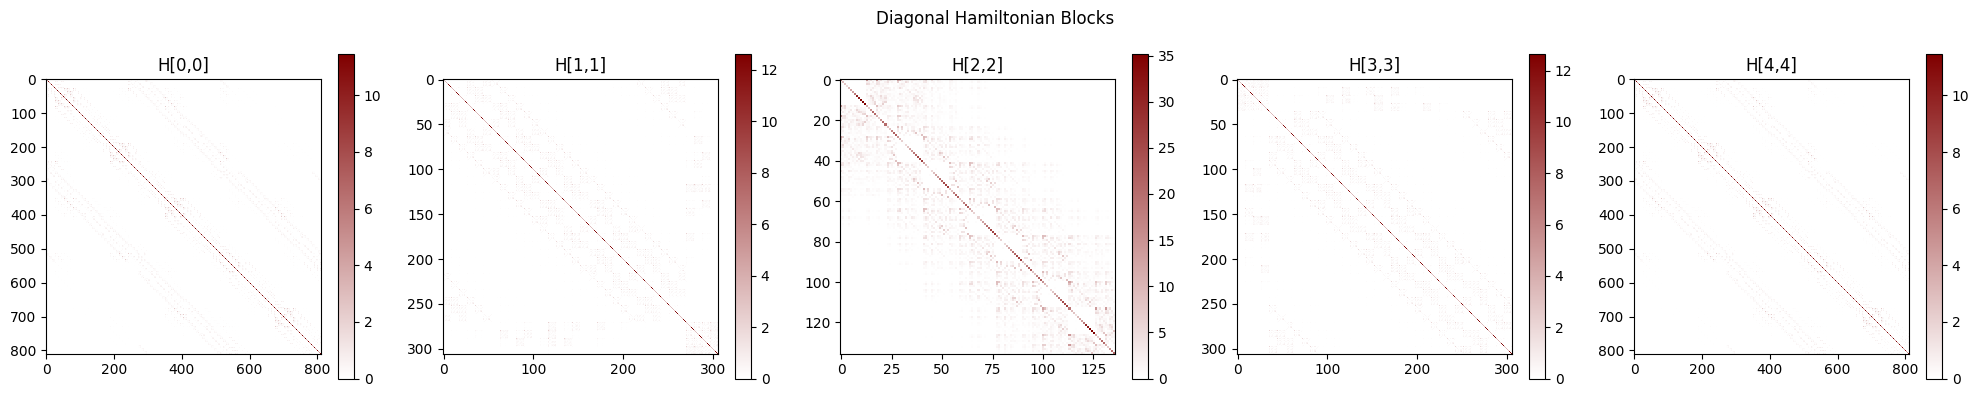

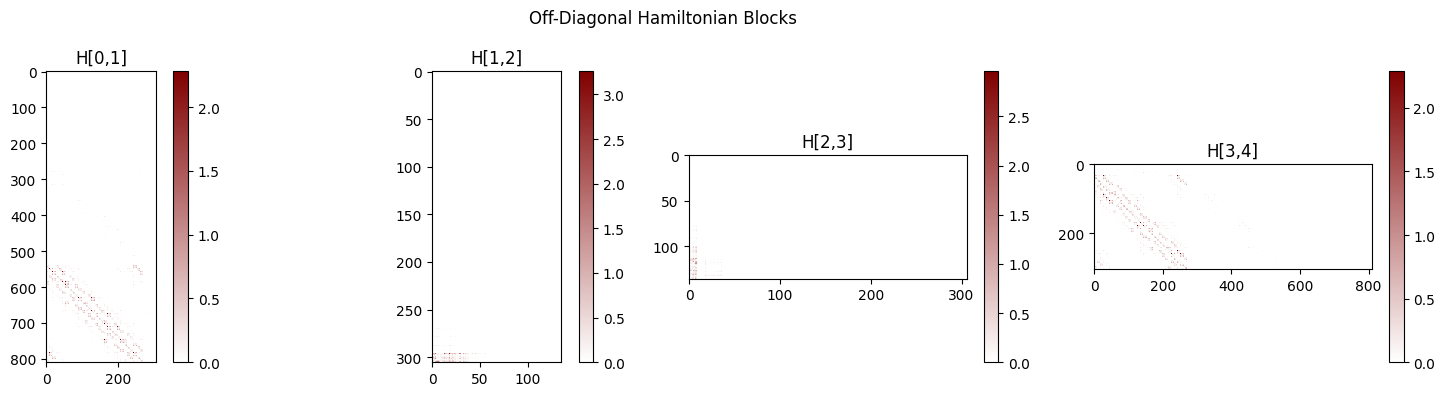

In [32]:
n_diag = len(hs_list_ii)
n_offdiag = len(hs_list_ij)

fig, axes = plt.subplots(1, n_diag, figsize=(4 * n_diag, 4))
for i, (Hii, _) in enumerate(hs_list_ii):
    ax = axes[i]
    im = ax.imshow(np.abs(Hii), cmap=maroon_cmap, interpolation="nearest")
    ax.set_title(f"H[{i},{i}]")
    plt.colorbar(im, ax=ax)
plt.suptitle("Diagonal Hamiltonian Blocks")
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(1, n_offdiag, figsize=(4 * n_offdiag, 4))
for i, (Hij, _) in enumerate(hs_list_ij):
    ax = axes[i]
    im = ax.imshow(np.abs(Hij), cmap=maroon_cmap, interpolation="nearest")
    ax.set_title(f"H[{i},{i+1}]")
    plt.colorbar(im, ax=ax)
plt.suptitle("Off-Diagonal Hamiltonian Blocks")
plt.tight_layout()
plt.show()

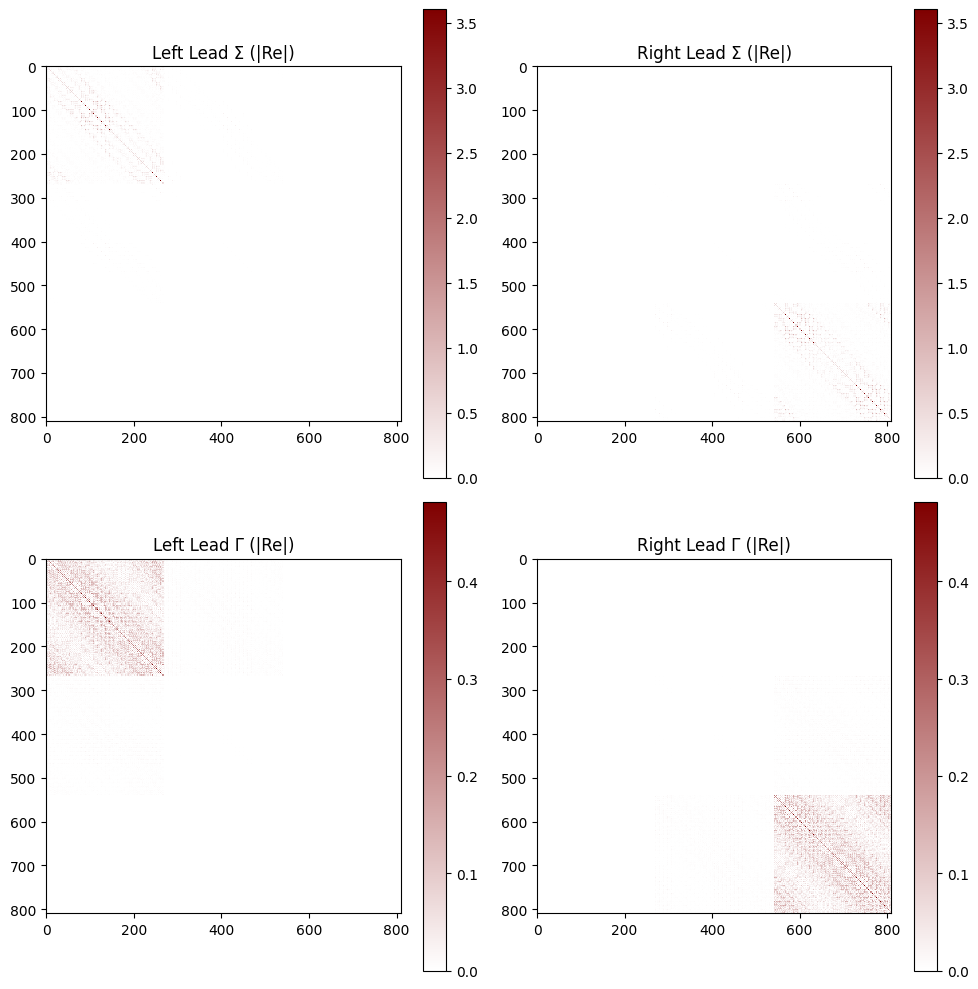

In [33]:
leads_se = np.load("./output/lowdin/self_energy.npy",allow_pickle=True)
E_sampler = np.linspace(-3, 3, 10)
se_left = np.array([leads_se[0].retarded(e) for e in E_sampler])
se_right = np.array([leads_se[1].retarded(e) for e in E_sampler])

gamma_left = compute_gamma_from_sigma(se_left[0])
gamma_right = compute_gamma_from_sigma(se_right[0])


# Plot Σ and Γ side by side
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Σ (real part)
im0 = axes[0, 0].imshow(np.abs(se_left[0].real), cmap=maroon_cmap, interpolation='nearest')
axes[0, 0].set_title('Left Lead Σ (|Re|)')
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(np.abs(se_right[0].real), cmap=maroon_cmap, interpolation='nearest')
axes[0, 1].set_title('Right Lead Σ (|Re|)')
fig.colorbar(im1, ax=axes[0, 1])

# Γ (broadening)
im2 = axes[1, 0].imshow(np.abs(gamma_left.real), cmap=maroon_cmap, interpolation='nearest')
axes[1, 0].set_title('Left Lead Γ (|Re|)')
fig.colorbar(im2, ax=axes[1, 0])

im3 = axes[1, 1].imshow(np.abs(gamma_right.real), cmap=maroon_cmap, interpolation='nearest')
axes[1, 1].set_title('Right Lead Γ (|Re|)')
fig.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.show()


### Retarded Green's function for leads

In [35]:
data_folder = "./output/lowdin"
H_subdiagonalized, S_subdiagonalized = np.load(f"{data_folder}/hs_los_lowdin.npy")

H_subdiagonalized = H_subdiagonalized.astype(np.complex128)
S_subdiagonalized = S_subdiagonalized.astype(np.complex128)

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao,
    S_leads_lcao,
    unit_cell_rep_in_leads,
    align=(0, H_subdiagonalized[0, 0, 0]),
)

remove_pbc(device_basis, H_subdiagonalized)
remove_pbc(device_basis, S_subdiagonalized)

self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id="right"
)

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)


### Test 1: Ensure correct implementation of various functions

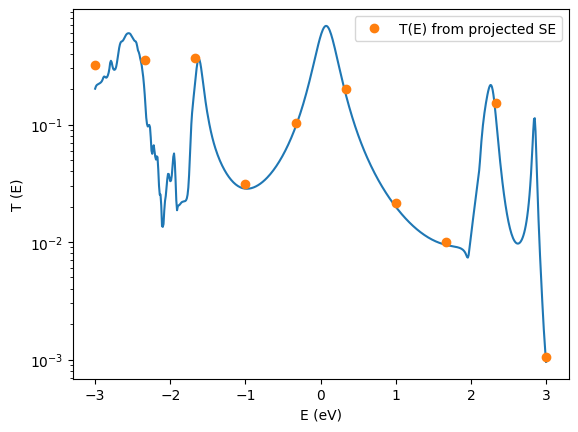

In [36]:
T_energy = []
E,T_dft_ref = np.load(f"{data_folder}/dft/ET.npy")

for i, omega in enumerate(E_sampler):

    sigma_L = self_energy[0].retarded(omega)
    sigma_R = self_energy[1].retarded(omega)

    sigma_L_padded = pad_self_energy_to_full_space(
        sigma_L,
        n_full=2368,
        direction="left"
    )

    sigma_R_padded = pad_self_energy_to_full_space(
        sigma_R,
        n_full=2368,
        direction="right"
    )

    G_mol = compute_greens_function_mol(
    H_mol=H_subdiagonalized[0],
    S_mol=S_subdiagonalized[0],
    sigma_L=sigma_L_padded,
    sigma_R=sigma_R_padded,
    omega=omega
    )

    T = compute_transmission(sigma_R=sigma_R_padded, sigma_L=sigma_L_padded, G_r=G_mol)

    T_energy.append(T)

plt.plot(E,T_dft_ref)
plt.plot(E_sampler, T_energy,'o' ,label="T(E) from projected SE")
plt.ylabel("T (E)")
plt.xlabel("E (eV)")
plt.yscale("log")
plt.legend()

The above test shows that my implementation of `pad_self_energy_to_full_space`, `compute_greens_function_mol`, and `compute_transmission` functions are correct. Any minor differences in the transmission function values are likely due to numerical inaccuracies. 

### Computing transmission function in a molecular subspace

In order to test if the projected self-energy method is working correctly, I need to compute the transmission function in the molecular subspace and compare it to the transmission function computed in the full device system.

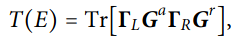

To compute the transmission function in the molecular subspace, since the leads' self-energies are projected onto the molecular subspace, the advanced and retarded Green's functions of the molecule should also be computed in the molecular subspace. 


Project lead + tip self-energies onto molecule subspace directly through coupling matrices. Method suggested by Mathieu. Similar concept is described in https://pubs.aip.org/aip/jcp/article/141/13/131104/352402 with the following formula:

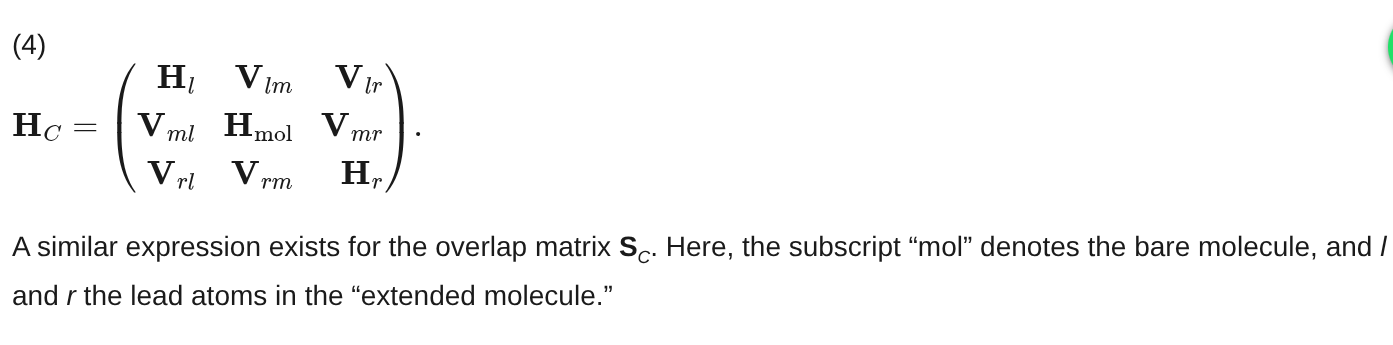

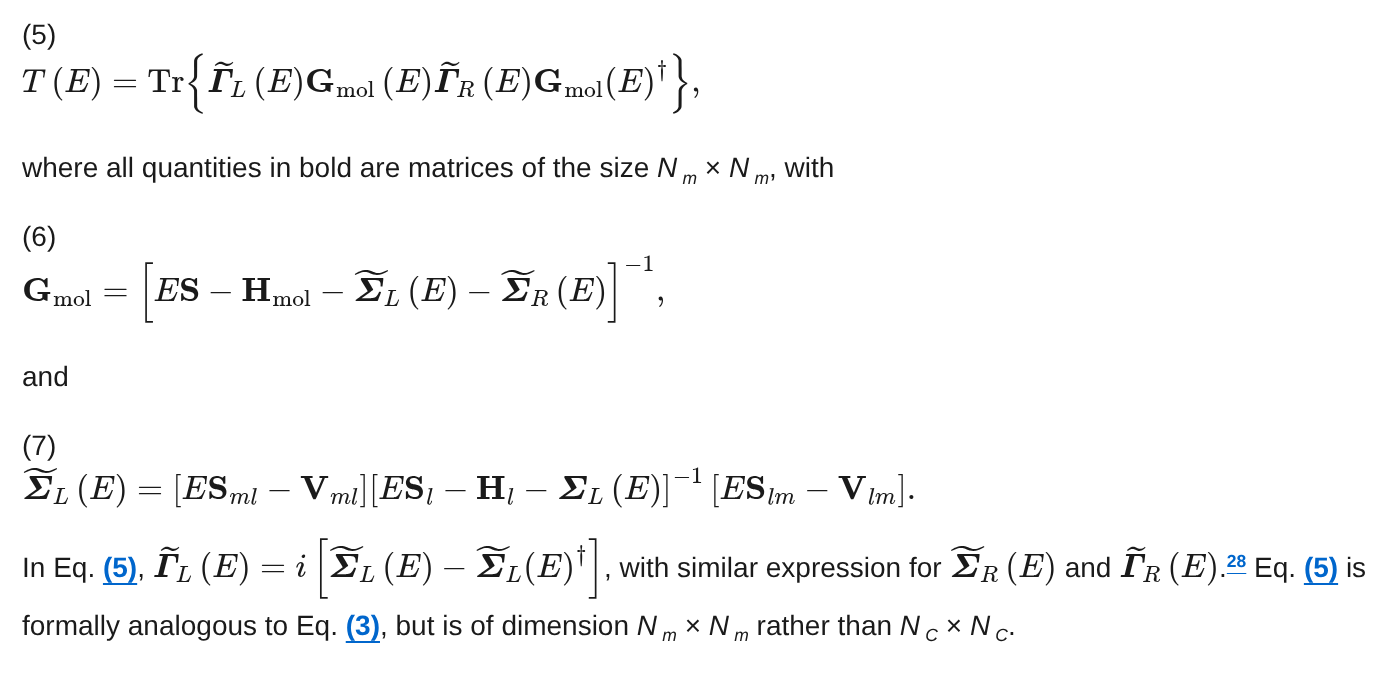


If we want to implement eqn. 7, we have to combine the lead and tip blocks of H and S since there are no direct couplings between lead and molecule.
This also means that the leads' self-energies (which only have dimensions of the lead subspace) have to be expanded to include the tip subspace as well before projecting onto the molecule subspace. I will expand by adding zeros for the tip subspace.

In [37]:
hs_ii_left, hs_ij_left = combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, "left")

hs_ii_right, hs_ij_right = combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, "right")

print("Left Lead - Diagonal blocks:")
for i, (Hii, Sii) in enumerate(hs_ii_left):
    print(f"Block {i}: H shape = {Hii.shape}, S shape = {Sii.shape}")

print("\nLeft Lead - Off-diagonal blocks:")
for i, (Hij, Sij) in enumerate(hs_ij_left):
    print(f"Block {i}-{i+1}: H shape = {Hij.shape}, S shape = {Sij.shape}")

print("\nRight Lead - Diagonal blocks:")
for i, (Hii, Sii) in enumerate(hs_ii_right):
    print(f"Block {i}: H shape = {Hii.shape}, S shape = {Sii.shape}")

print("\nRight Lead - Off-diagonal blocks:")
for i, (Hij, Sij) in enumerate(hs_ij_right):
    print(f"Block {i}-{i+1}: H shape = {Hij.shape}, S shape = {Sij.shape}")


Left Lead - Diagonal blocks:
Block 0: H shape = (1116, 1116), S shape = (1116, 1116)

Left Lead - Off-diagonal blocks:
Block 0-1: H shape = (1116, 136), S shape = (1116, 136)

Right Lead - Diagonal blocks:
Block 0: H shape = (1116, 1116), S shape = (1116, 1116)

Right Lead - Off-diagonal blocks:
Block 0-1: H shape = (136, 1116), S shape = (136, 1116)


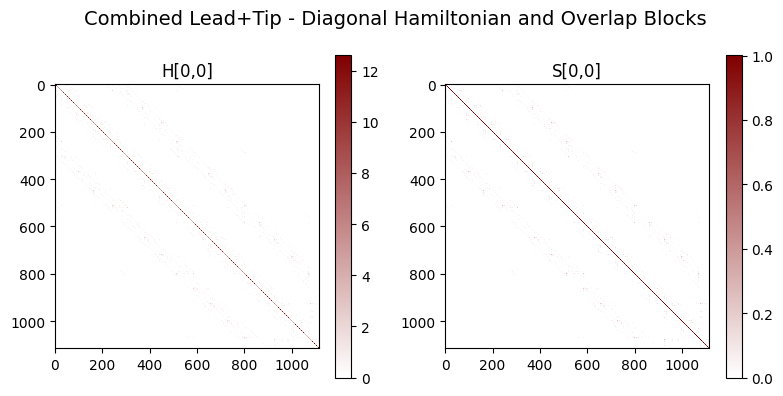

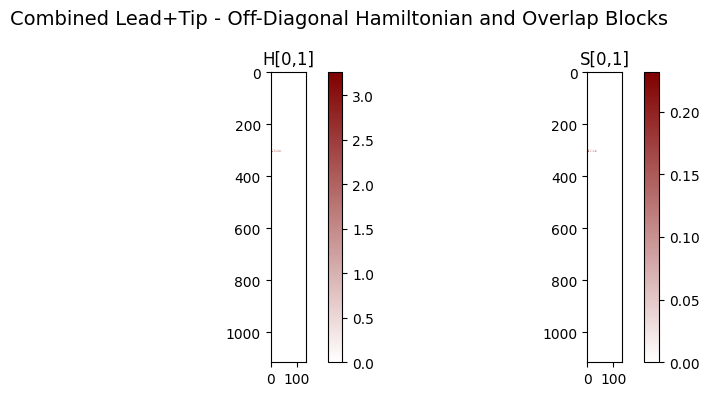

In [38]:
n_diag = len(hs_ii_left)
fig, axes = plt.subplots(n_diag, 2, figsize=(8, 4 * n_diag))

if n_diag == 1:
    axes = np.array([[axes[0], axes[1]]])

for i, (Hii, Sii) in enumerate(hs_ii_left):
    ax_H = axes[i, 0]
    ax_S = axes[i, 1]

    im_H = ax_H.imshow(np.abs(Hii), cmap=maroon_cmap, interpolation="nearest")
    ax_H.set_title(f"H[{i},{i}]")
    plt.colorbar(im_H, ax=ax_H)

    im_S = ax_S.imshow(np.abs(Sii), cmap=maroon_cmap, interpolation="nearest")
    ax_S.set_title(f"S[{i},{i}]")
    plt.colorbar(im_S, ax=ax_S)

plt.suptitle("Combined Lead+Tip - Diagonal Hamiltonian and Overlap Blocks", fontsize=14)
plt.tight_layout()
plt.show()

n_offdiag = len(hs_ij_left)
fig, axes = plt.subplots(n_offdiag, 2, figsize=(8, 4 * n_offdiag))

if n_offdiag == 1:
    axes = np.array([[axes[0], axes[1]]])

for i, (Hij, Sij) in enumerate(hs_ij_left):
    ax_H = axes[i, 0]
    ax_S = axes[i, 1]

    im_H = ax_H.imshow(np.abs(Hij), cmap=maroon_cmap, interpolation="nearest")
    ax_H.set_title(f"H[{i},{i+1}]")
    plt.colorbar(im_H, ax=ax_H)

    im_S = ax_S.imshow(np.abs(Sij), cmap=maroon_cmap, interpolation="nearest")
    ax_S.set_title(f"S[{i},{i+1}]")
    plt.colorbar(im_S, ax=ax_S)

plt.suptitle("Combined Lead+Tip - Off-Diagonal Hamiltonian and Overlap Blocks", fontsize=14)
plt.tight_layout()
plt.show()


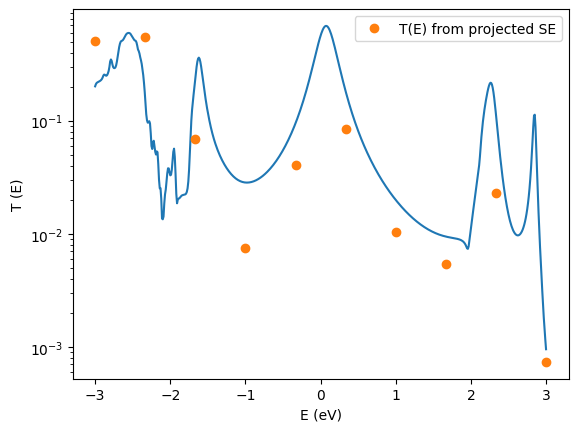

In [40]:
T_energy = []
H_mol, S_mol = hs_list_ii[2]
for i, omega in enumerate(E_sampler):

    sigma_L = self_energy[0].retarded(omega)
    sigma_R = self_energy[1].retarded(omega)

    sigma_L_padded = pad_self_energy_to_full_space(
        sigma_L,
        n_full=hs_ii_left[0][0].shape[0],
        direction="left"
    )
    sigma_L = compute_projected_self_energy(
        hs_list_ii=hs_ii_left,
        hs_list_ij=hs_ij_left,
        sigma_lead=sigma_L_padded,
        omega=omega,
        direction="left"
    )

    sigma_R_padded = pad_self_energy_to_full_space(
        sigma_R,
        n_full=hs_ii_right[0][0].shape[0],
        direction="right"
    )
    sigma_R = compute_projected_self_energy(
        hs_list_ii=hs_ii_right,
        hs_list_ij=hs_ij_right,
        sigma_lead=sigma_R_padded,
        omega=omega,
        direction="right"
    )


    G_mol = compute_greens_function_mol(
    H_mol=H_mol,
    S_mol=S_mol,
    sigma_L=sigma_L,
    sigma_R=sigma_R,
    omega=omega
    )
    T = compute_transmission(sigma_R=sigma_R, sigma_L=sigma_L, G_r=G_mol)

    T_energy.append(T)

plt.plot(E,T_dft_ref)
plt.plot(E_sampler, T_energy,'o' ,label="T(E) from projected SE")
plt.ylabel("T (E)")
plt.xlabel("E (eV)")
plt.yscale("log")
plt.legend()


In [23]:
H_lcao, S_lcao = np.load("output/hs_lcao.npy")

H_lcao = H_lcao.astype(np.complex128)
S_lcao = S_lcao.astype(np.complex128)


kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao,
    S_leads_lcao,
    unit_cell_rep_in_leads,
    align=(0, H_lcao[0, 0, 0]),
)

remove_pbc(device_basis, H_lcao)
remove_pbc(device_basis, S_lcao)

self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id="right"
)

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_lcao[0], S_lcao[0]
)

hs_ii_left, hs_ij_left = combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, "left")
hs_ii_right, hs_ij_right = combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, "right")

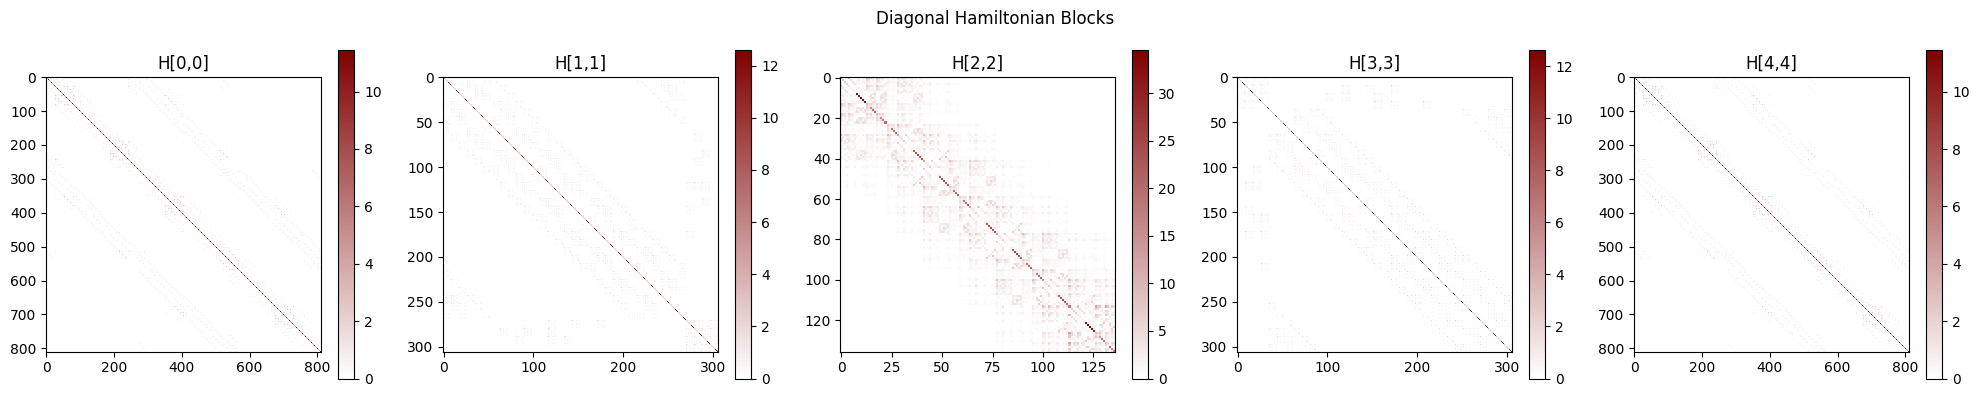

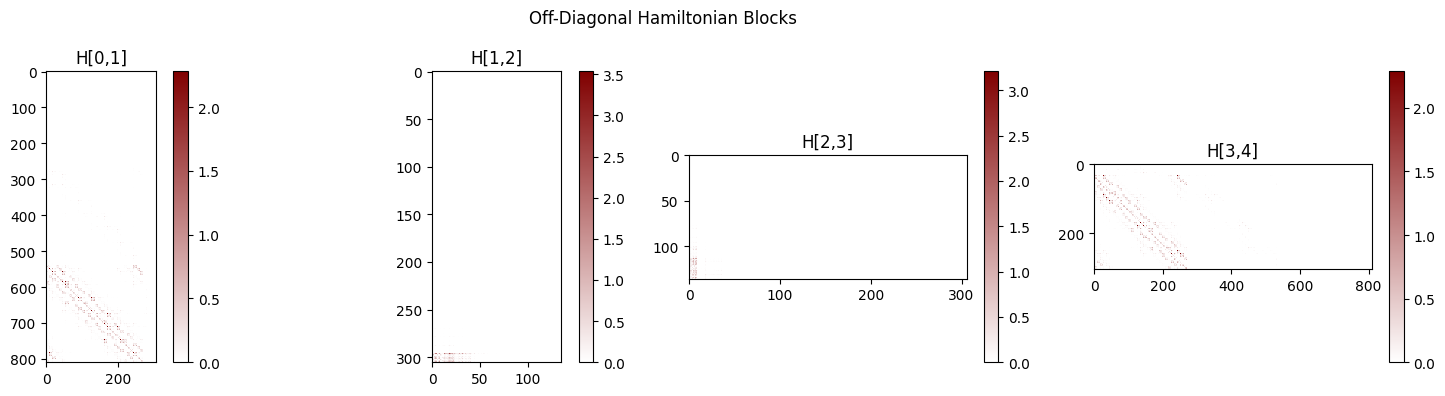

In [24]:
n_diag = len(hs_list_ii)
n_offdiag = len(hs_list_ij)

fig, axes = plt.subplots(1, n_diag, figsize=(4 * n_diag, 4))
for i, (Hii, _) in enumerate(hs_list_ii):
    ax = axes[i]
    im = ax.imshow(np.abs(Hii), cmap=maroon_cmap, interpolation="nearest")
    ax.set_title(f"H[{i},{i}]")
    plt.colorbar(im, ax=ax)
plt.suptitle("Diagonal Hamiltonian Blocks")
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(1, n_offdiag, figsize=(4 * n_offdiag, 4))
for i, (Hij, _) in enumerate(hs_list_ij):
    ax = axes[i]
    im = ax.imshow(np.abs(Hij), cmap=maroon_cmap, interpolation="nearest")
    ax.set_title(f"H[{i},{i+1}]")
    plt.colorbar(im, ax=ax)
plt.suptitle("Off-Diagonal Hamiltonian Blocks")
plt.tight_layout()
plt.show()

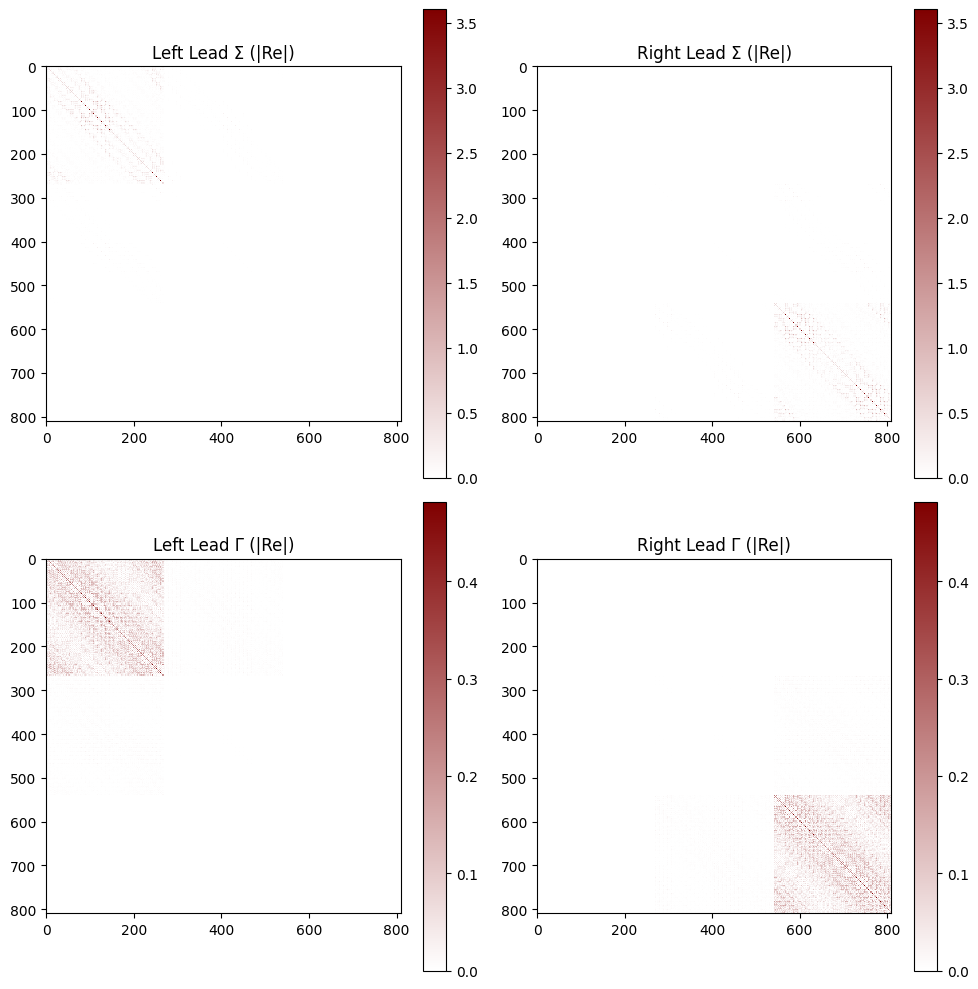

In [25]:
se_left = np.array([self_energy[0].retarded(e) for e in E_sampler])
se_right = np.array([self_energy[1].retarded(e) for e in E_sampler])

gamma_left = compute_gamma_from_sigma(se_left[0])
gamma_right = compute_gamma_from_sigma(se_right[0])


# Plot Σ and Γ side by side
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Σ (real part)
im0 = axes[0, 0].imshow(np.abs(se_left[0].real), cmap=maroon_cmap, interpolation='nearest')
axes[0, 0].set_title('Left Lead Σ (|Re|)')
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(np.abs(se_right[0].real), cmap=maroon_cmap, interpolation='nearest')
axes[0, 1].set_title('Right Lead Σ (|Re|)')
fig.colorbar(im1, ax=axes[0, 1])

# Γ (broadening)
im2 = axes[1, 0].imshow(np.abs(gamma_left.real), cmap=maroon_cmap, interpolation='nearest')
axes[1, 0].set_title('Left Lead Γ (|Re|)')
fig.colorbar(im2, ax=axes[1, 0])

im3 = axes[1, 1].imshow(np.abs(gamma_right.real), cmap=maroon_cmap, interpolation='nearest')
axes[1, 1].set_title('Right Lead Γ (|Re|)')
fig.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.show()


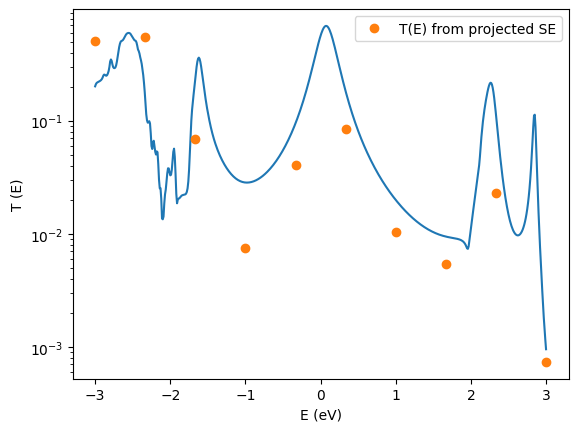

In [27]:
T_energy = []
H_mol, S_mol = hs_list_ii[2]
for i, omega in enumerate(E_sampler):

    sigma_L = self_energy[0].retarded(omega)
    sigma_R = self_energy[1].retarded(omega)

    sigma_L_padded = pad_self_energy_to_full_space(
        sigma_L,
        n_full=hs_ii_left[0][0].shape[0],
        direction="left"
    )
    sigma_L = compute_projected_self_energy(
        hs_list_ii=hs_ii_left,
        hs_list_ij=hs_ij_left,
        sigma_lead=sigma_L_padded,
        omega=omega,
        direction="left"
    )

    sigma_R_padded = pad_self_energy_to_full_space(
        sigma_R,
        n_full=hs_ii_right[0][0].shape[0],
        direction="right"
    )
    sigma_R = compute_projected_self_energy(
        hs_list_ii=hs_ii_right,
        hs_list_ij=hs_ij_right,
        sigma_lead=sigma_R_padded,
        omega=omega,
        direction="right"
    )


    G_mol = compute_greens_function_mol(
    H_mol=H_mol,
    S_mol=S_mol,
    sigma_L=sigma_L,
    sigma_R=sigma_R,
    omega=omega
    )
    T = compute_transmission(sigma_R=sigma_R, sigma_L=sigma_L, G_r=G_mol)

    T_energy.append(T)

plt.plot(E,T_dft_ref)
plt.plot(E_sampler, T_energy,'o' ,label="T(E) from projected SE")
plt.ylabel("T (E)")
plt.xlabel("E (eV)")
plt.yscale("log")
plt.legend()


Given that the projected self-energy method yields similar results for both Lowdin orthonormalized and MO basis sets, I can conclude that the basis set transformation is not the source of the discrepancy. Does this imply that the projected self-energy method loses accuracy/information regardless of the basis set used?

### What allows Ferretti et al to implement this method without projections into a molecular subspace?

References: 

1. https://doi.org/10.1103/PhysRevB.72.125114
2. https://doi.org/10.1103/PhysRevLett.94.116802

Is it because they use a model that folds the 3D problem into a 1D problem shown in their Figure?


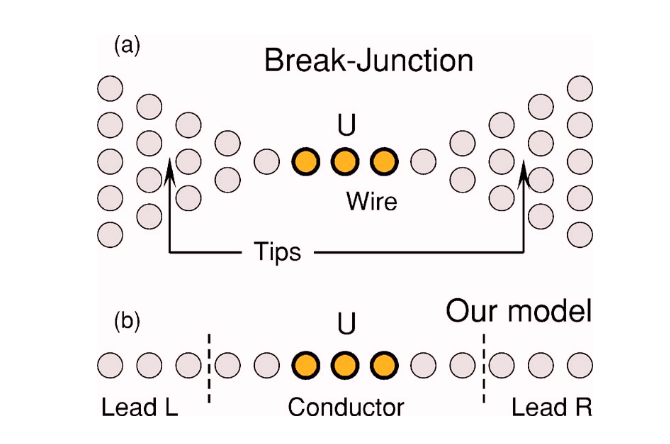 

Or they use equation 6 to project leads onto the conductor basis.

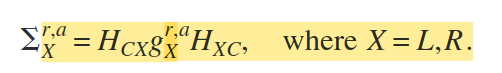

This form seems similar to the one I have implemented in this notebook (i.e. Eqn 7 of https://pubs.aip.org/aip/jcp/article/141/13/131104/352402). However, note that their conductor region includes part of the leads as well (i.e. is not just the molecule).


Also, look at a similar form Ferretti et al uses in this paper: https://doi.org/10.1103/PhysRevB.75.075102

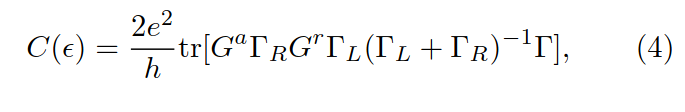

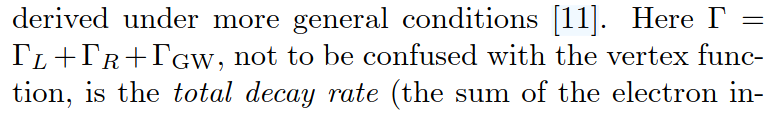



It's not exactly the same form as in his first paper, but similar. But the Gamma matrix is a sum of leads and correlation self-energies here. So no direct multiplication of non-overlapping subspaces.

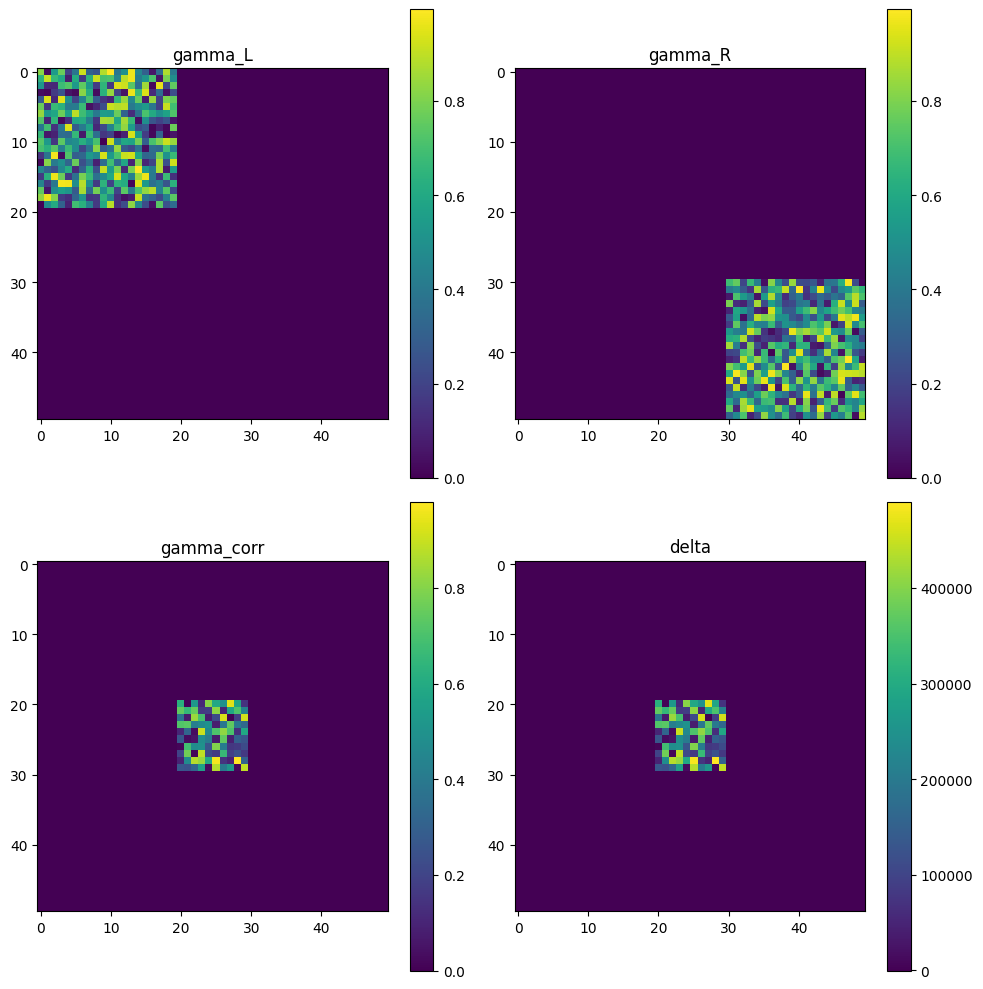

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Matrix size
N = 50
delta_reg = 1e-6    # small regularization parameter

# Initialize all matrices as zeros
gamma_L = np.zeros((N, N))
gamma_R = np.zeros((N, N))
gamma_corr = np.zeros((N, N))

# Fill the specified blocks
gamma_L[:20, :20] = np.random.rand(20, 20)          # top-left block
gamma_R[-20:, -20:] = np.random.rand(20, 20)        # bottom-right block
gamma_corr[20:30, 20:30] = np.random.rand(10, 10)   # central block

# Compute delta with diagonal regularization
A = gamma_L + gamma_R
A_reg = A + 2 * delta_reg * np.eye(N)    # regularized matrix

delta = np.linalg.inv(A_reg) @ (A + gamma_corr)

# Visualize
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(gamma_L)
plt.title("gamma_L")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(gamma_R)
plt.title("gamma_R")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(gamma_corr)
plt.title("gamma_corr")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(delta)
plt.title("delta")
plt.colorbar()

plt.tight_layout()
plt.show()


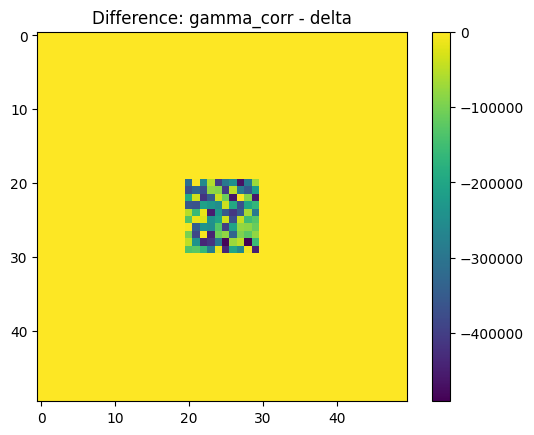

In [5]:
diff = gamma_corr - delta
plt.imshow(diff)
plt.title("Difference: gamma_corr - delta")
plt.colorbar()